In [1]:
%load_ext autoreload
%autoreload 2

# Toy dataset creation

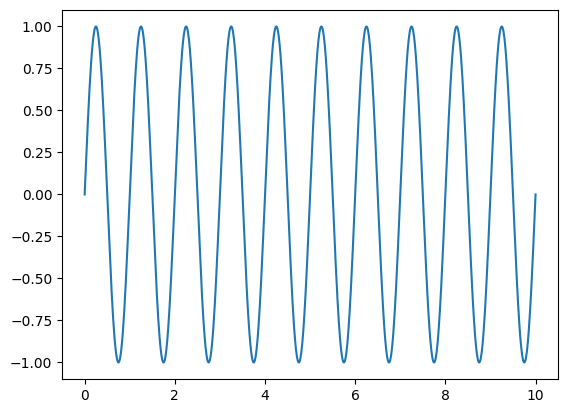

In [2]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(0.0, 10.0, 1000)

sinus = np.sin(2 * np.pi * x)

plt.plot(x, sinus)
plt.show()

# ABBA Training

Learn transform and apply reverse transform to the data and visualize the results

brstocaqkldbjiegfcahkldbjiegfcahkldbjiegfcahkldbjiegfcahkldbjiegfcahkmdbjiegfcahnmdbjiegfcahnmdbjiegfcahnmdbjiegfcahnmdp


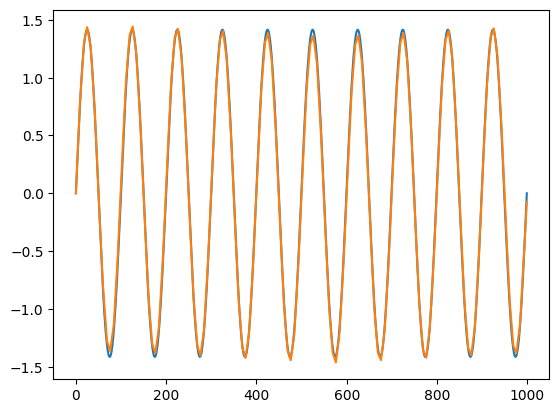

In [3]:
from src.abba import ABBA

abba = ABBA(increment_threshold=0.01, max_length=10)

standardized_sinus = abba.standardize(sinus)

abba.learn_transform(standardized_sinus)

string_representation = abba.apply_transform_to_str(standardized_sinus)
print(string_representation)

reconstructed_linear = abba.apply_inverse_transform_from_str(string_representation)

plt.plot(abba.standardize(sinus))
plt.plot(reconstructed_linear)
plt.show()

Train, test split and learn transform only on the train data

In [4]:
import torch

from src.forecasting.dataset import get_datasets_and_loaders

batch_size = 64


test_split_ratio = 0.2
sequence_length = 10


abba = ABBA(increment_threshold=0.01, max_length=10)

time_series = abba.standardize(sinus)

raw_train, raw_test, train_loader, test_loader = get_datasets_and_loaders(
    time_series,
    batch_size=batch_size,
    test_split_ratio=test_split_ratio,
    sequence_length=sequence_length,
    num_workers=0,
    abba=abba,
)

Average time series length per symbol: 8.333333333333334


Train a model on the transformed data

In [6]:
from src.forecasting.models import ABBAForecastingLSTM
from src.forecasting.training import train_loop, accuracy, mse, test_loop
import torch

model = ABBAForecastingLSTM(
    language_size=len(abba.language),
    hidden_size=64,
    num_layers=2,
)


loss_function = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 50

for epoch in range(num_epochs):
    train_loss, train_accuracy = train_loop(
        model,
        train_loader,
        optimizer,
        loss_function,
        accuracy,
        device=torch.device("cpu"),
    )

    test_loss, test_accuracy = test_loop(
        model,
        test_loader,
        loss_function,
        accuracy,
        device=torch.device("cpu"),
    )

    print(
        f"Epoch {epoch} - Train Loss: {train_loss:.3f} - Train Accuracy: {train_accuracy:.3f} - Test Loss: {test_loss:.3f} - Test Accuracy: {test_accuracy:.3f}"
    )

Epoch 0 - Train Loss: 0.070 - Train Accuracy: 0.012 - Test Loss: 0.124 - Test Accuracy: 0.042
Epoch 1 - Train Loss: 0.068 - Train Accuracy: 0.081 - Test Loss: 0.124 - Test Accuracy: 0.083
Epoch 2 - Train Loss: 0.068 - Train Accuracy: 0.163 - Test Loss: 0.123 - Test Accuracy: 0.167
Epoch 3 - Train Loss: 0.067 - Train Accuracy: 0.244 - Test Loss: 0.122 - Test Accuracy: 0.167
Epoch 4 - Train Loss: 0.067 - Train Accuracy: 0.244 - Test Loss: 0.120 - Test Accuracy: 0.167
Epoch 5 - Train Loss: 0.066 - Train Accuracy: 0.244 - Test Loss: 0.119 - Test Accuracy: 0.167
Epoch 6 - Train Loss: 0.065 - Train Accuracy: 0.244 - Test Loss: 0.117 - Test Accuracy: 0.167
Epoch 7 - Train Loss: 0.063 - Train Accuracy: 0.244 - Test Loss: 0.115 - Test Accuracy: 0.167
Epoch 8 - Train Loss: 0.061 - Train Accuracy: 0.244 - Test Loss: 0.112 - Test Accuracy: 0.167
Epoch 9 - Train Loss: 0.059 - Train Accuracy: 0.256 - Test Loss: 0.109 - Test Accuracy: 0.292
Epoch 10 - Train Loss: 0.057 - Train Accuracy: 0.372 - Test 

Evaluate the results both quantitatively and qualitatively

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.

Optimal prediction DTW:  0.015254824597178005
Autoregressive prediction DTW:  0.03439377512683271
Non Autoregressive prediction DTW:  0.06742539212364133


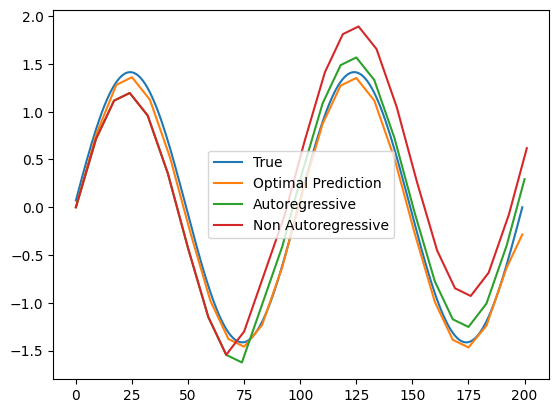

In [7]:
from torch.utils.data import Dataset
from src.forecasting.training import forecast
from dtw import dtw


y_test = [test_loader.dataset[i][1] for i in range(len(test_loader.dataset))]  # type: ignore

test_data = abba.apply_inverse_transform(np.array(y_test))

autoregressive_predictions = forecast(
    model, test_loader.dataset, auto_regressive=True, abba=abba
)
non_autoregressive_predictions = forecast(
    model, test_loader.dataset, auto_regressive=False, abba=abba
)

print("Optimal prediction DTW: ", dtw(test_data, raw_test).normalizedDistance)
print(
    "Autoregressive prediction DTW: ",
    dtw(autoregressive_predictions, raw_test).normalizedDistance,
)
print(
    "Non Autoregressive prediction DTW: ",
    dtw(non_autoregressive_predictions, raw_test).normalizedDistance,
)


plt.plot(raw_test, label="True")
plt.plot(test_data, label="Optimal Prediction")
plt.plot(autoregressive_predictions, label="Autoregressive")
plt.plot(non_autoregressive_predictions, label="Non Autoregressive")
plt.legend()
plt.show()

# Comparison with classical LSTM

In [8]:
import torch

from src.forecasting.dataset import get_datasets_and_loaders

batch_size = 64


test_split_ratio = 0.2
sequence_length = 83

time_series = abba.standardize(sinus)

raw_train, raw_test, train_loader, test_loader = get_datasets_and_loaders(
    time_series,
    batch_size=batch_size,
    test_split_ratio=test_split_ratio,
    sequence_length=sequence_length,
    num_workers=0,
    abba=None,
)

In [9]:
from src.forecasting.models import RegressionForecastingLSTM
from src.forecasting.training import train_loop, accuracy, mse, test_loop
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model = RegressionForecastingLSTM(
    hidden_size=64,
    num_layers=2,
).to(device)

loss_function = torch.nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 50

for epoch in range(num_epochs):
    train_loss, train_mse = train_loop(
        model,
        train_loader,
        optimizer,
        loss_function,
        mse,
        device=device,
    )

    test_loss, test_mse = test_loop(
        model,
        test_loader,
        loss_function,
        mse,
        device=device,
    )

    print(
        f"Epoch {epoch} - Train Loss: {train_loss*1000:.3f} - Train MSE: {train_mse*1000:.3f} - Test Loss: {test_loss*1000:.3f} - Test MSE: {test_mse*1000:.3f}"
    )

Epoch 0 - Train Loss: 1.681 - Train MSE: 857.306 - Test Loss: 9.720 - Test MSE: 614.174
Epoch 1 - Train Loss: 0.425 - Train MSE: 355.339 - Test Loss: 3.829 - Test MSE: 199.116
Epoch 2 - Train Loss: 0.376 - Train MSE: 154.583 - Test Loss: 1.999 - Test MSE: 93.059
Epoch 3 - Train Loss: 0.098 - Train MSE: 63.598 - Test Loss: 0.594 - Test MSE: 33.455
Epoch 4 - Train Loss: 0.013 - Train MSE: 20.239 - Test Loss: 0.224 - Test MSE: 12.761
Epoch 5 - Train Loss: 0.012 - Train MSE: 8.808 - Test Loss: 0.065 - Test MSE: 3.406
Epoch 6 - Train Loss: 0.004 - Train MSE: 2.158 - Test Loss: 0.021 - Test MSE: 1.121
Epoch 7 - Train Loss: 0.002 - Train MSE: 0.893 - Test Loss: 0.007 - Test MSE: 0.403
Epoch 8 - Train Loss: 0.001 - Train MSE: 0.296 - Test Loss: 0.004 - Test MSE: 0.223
Epoch 9 - Train Loss: 0.000 - Train MSE: 0.124 - Test Loss: 0.002 - Test MSE: 0.085
Epoch 10 - Train Loss: 0.000 - Train MSE: 0.066 - Test Loss: 0.001 - Test MSE: 0.073
Epoch 11 - Train Loss: 0.000 - Train MSE: 0.069 - Test Loss:

Autoregressive prediction DTW:  0.017580078503831233
Non Autoregressive prediction DTW:  0.002528682995007057


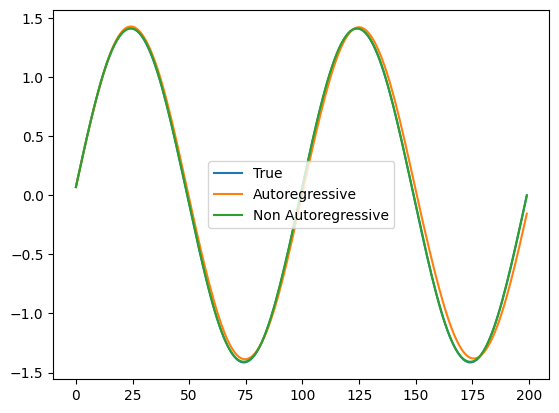

In [40]:
from torch.utils.data import Dataset
from src.forecasting.training import forecast
from dtw import dtw


test_data = np.array([test_loader.dataset[i][1] for i in range(len(test_loader.dataset))])  # type: ignore

model.to(torch.device("cpu"))

autoregressive_predictions = forecast(
    model, test_loader.dataset, auto_regressive=True, abba=None
)
non_autoregressive_predictions = forecast(
    model, test_loader.dataset, auto_regressive=False, abba=None
)

print(
    "Autoregressive prediction DTW: ",
    dtw(autoregressive_predictions, raw_test).normalizedDistance,
)
print(
    "Non Autoregressive prediction DTW: ",
    dtw(non_autoregressive_predictions, raw_test).normalizedDistance,
)


plt.plot(raw_test, label="True")
plt.plot(autoregressive_predictions, label="Autoregressive")
plt.plot(non_autoregressive_predictions, label="Non Autoregressive")
plt.legend()
plt.show()